## Importing Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

In [4]:
train= pd.read_csv('train.csv')
train.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [92]:
print('There are {} rows and {} columns in train'.format(train.shape[0],train.shape[1]))


There are 7613 rows and 5 columns in train


## Class Distribution

> 1. Before we begin with anything else,let's check the class distribution.There are only two classes 0 and 1.
> 2. Class Distribution is balanced



/home/azure/.pyenv/versions/mlflow_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'samples')

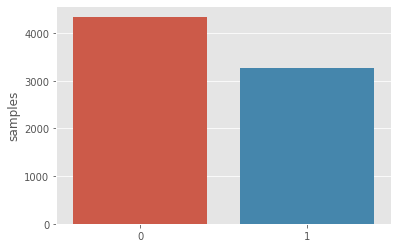

In [7]:
x=train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

class 0 ( No disaster) than class 1 ( disaster tweets)

## EDA 

### 1. Char count 

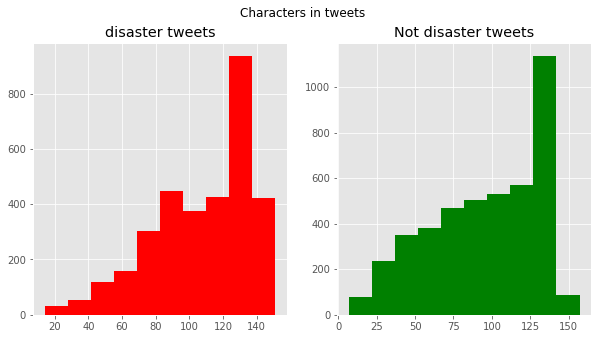

In [9]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

### 2. Word Count

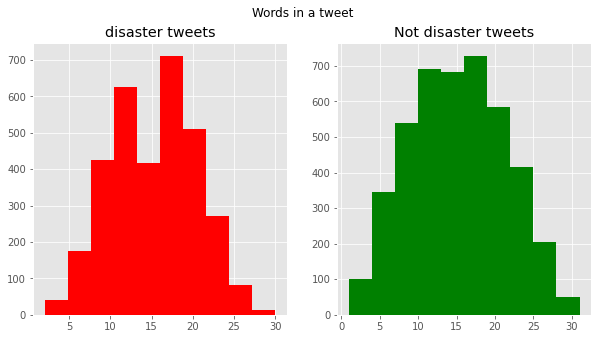

In [10]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

### 3. Avergae word length

/home/azure/.pyenv/versions/mlflow_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/azure/.pyenv/versions/mlflow_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each tweet')

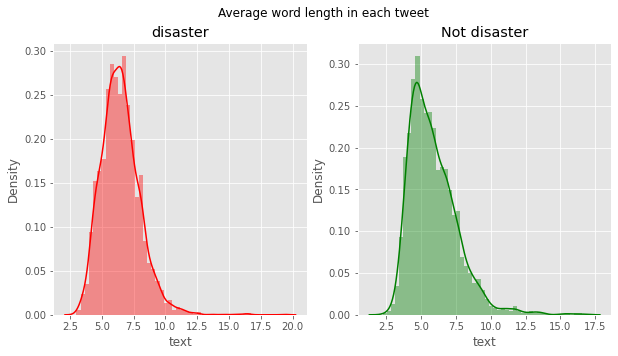

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

## Text Cleaining
> 1. Remove special keyword
> 2. Remove html tags
> 3. Remove URL
> 4. Remove special char
> 5. Apply Spell checker

In [54]:
from bs4 import BeautifulSoup
import re
def sanitize_text(document):
    if document == None:
        document = ""
    text = BeautifulSoup(document, 'html5lib').get_text()
    url = re.compile(r'https?://\S+|www\.\S+')
    text=url.sub(r'',text)
    review_text = re.sub("[^a-zA-Z]", " ", text)
    review_text = re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', review_text)
    review_text = review_text.lower()
    review_text_list = review_text.split(" ")
    review_text_list = [x.strip() for x in review_text_list]
    review_text = " ".join(review_text_list)
    document = re.sub(' +', ' ', review_text).strip()
    return document

In [57]:
sanitize_text(train['text'].iloc[33])

'africanbaze breaking news nigeria flag set ablaze in aba'

In [61]:
train['text']=train['text'].apply(lambda x:sanitize_text(x) )

## Create Embedding

> Here we use 'all-MiniLM-L6-v2' from Sentence transformer (https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)

In [66]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

2022-08-03 06:28:08.699033: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:
2022-08-03 06:28:08.699099: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [67]:
embed_text = model.encode(train['text'].tolist(),convert_to_tensor=False, convert_to_numpy=True,normalize_embeddings=True)

## Classification Model

> Here we use Random Forest

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc,roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score,classification_report,accuracy_score
from sklearn.metrics import precision_score,recall_score

In [70]:
x_train, x_test, y_train, y_test = train_test_split(embed_text, train['target'], test_size = .25, random_state = 18)

In [71]:
best_params={'criterion': 'entropy',
 'max_depth': 10.0,
 'max_features': 'sqrt',
 'min_samples_leaf': 6,
 'min_samples_split': 10,
 'n_estimators': 289}

## Training

In [72]:
clf = RandomForestClassifier(**best_params, random_state = 18)
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
y_true=y_test.to_numpy()

## Evaluation



In [73]:
print('roc_auc : {}'.format(roc_auc_score(y_test, y_pred)))
print('accuracy score : {}'.format(accuracy_score(y_test, y_pred)))
print('presion score : {}'.format(precision_score(y_test, y_pred)))
print('recall score : {}'.format(recall_score(y_test, y_pred)))
print('f1 score : {}'.format(f1_score(y_test, y_pred)))

roc_auc : 0.7922694975707023
accuracy score : 0.8093487394957983
presion score : 0.8643533123028391
recall score : 0.6642424242424242
f1 score : 0.7511994516792323


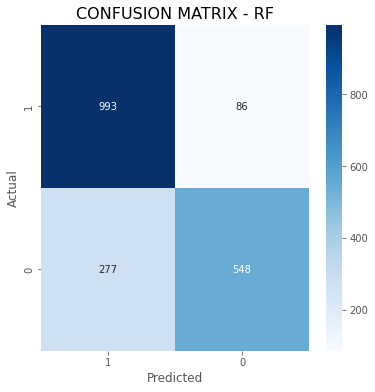

In [90]:
##Confusion Metric
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=train['target'].unique(), 
            yticklabels=train['target'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - RF", size=16);

In [91]:
## Classification Report
print(classification_report(
    y_true,
    y_pred
))

              precision    recall  f1-score   support

           0       0.78      0.92      0.85      1079
           1       0.86      0.66      0.75       825

    accuracy                           0.81      1904
   macro avg       0.82      0.79      0.80      1904
weighted avg       0.82      0.81      0.80      1904

